# Work in Progress

## Author: [Mateo Velásquez-Giraldo](https://mv77.github.io/)

In [1]:
# Preliminaries
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType
)

from HARK.ConsumptionSaving.tests.test_IndShockConsumerType import (
    dict_harmenberg    
)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Description of the problem

In macroeconomic models with heterogeneous agents, the permanent component of agents' income ($\textbf{P}_t$) often follows a geometric random walk. At any time, these economies include agents with different levels of permanent income. To find an aggregate characteristic of these economies such as aggregate consumption $\bar{\textbf{C}}_t$, one must integrate over permanent income and all the other relevant state variables

\begin{equation*}
\bar{\textbf{C}}_t = \int \int C(\text{State},\textbf{P}) \times f_t(\text{State},\textbf{P}) \, d\text{State}\, d\textbf{P}, 
\end{equation*}

where $\text{State}$ denotes any other state variables that consumption might depend on, $C(\cdot,\cdot)$ is the individual consumption function, and $f_t(\cdot,\cdot)$ is the joint density function of permanent income and the other state variables at time $t$.

Models like the traditional Buffer-Stock-Saving agent with CRRA utility [CITE CARROLL 2021] are homothetic in permanent income. This means that one can solve for a normalized policy function $c(\cdot)$ such that

\begin{equation*}
    C(\text{State},\textbf{P}) = c\left(\frac{1}{\textbf{P}}\times \text{State}\right)\times \textbf{P} \qquad \forall \, (\text{State},\textbf{P}).
\end{equation*}

In practice, this implies that one can defined a normalized state vector $\widetilde{\text{State}} = \text{State}/\textbf{P}$ and solve for the normalized policy function. This eliminates one dimension of the optimization problem problem, $\textbf{P}$.

While convenient for the solution of the agents' optimization problem, homotheticity has not simplified our aggregation calculations as we still have

\begin{equation*}
\begin{split}
\bar{\textbf{C}}_t =& \int \int C(\text{State},\textbf{P}) \times f_t(\text{State},\textbf{P}) \, d\text{State}\, d\textbf{P}\\
=& \int \int c\left(\frac{1}{\textbf{P}}\times \text{State}\right)\times \textbf{P} \times f_t(\text{State},\textbf{P}) \, d\text{State}\, d\textbf{P},
\end{split}
\end{equation*}

which depends on $P$.

To further complicate matters, we usually do not have analytical expressions for $c(\cdot)$ or $f_t(\text{State},\textbf{P})$. What we do in practice is to simulate a population $I$ of agents for a large number of periods $T$ using the model's policy functions and transition equations. The result is a set of observations $\{\text{State}_{i,t},\textbf{P}_{i,t}\}_{i\in I, 0\leq t\leq T}$ which we then use to approximate

\begin{equation*}
\bar{\textbf{C}}_t \approx \frac{1}{|I|}\sum_{i \in I} c\left(\frac{1}{\textbf{P}_{i,t}}\times \text{State}_{i,t}\right)\times \textbf{P}_{i,t}. 
\end{equation*}

At least two features of the previous strategy are unpleasant:
- We have to simulate the distribution of permanent income, even though the model's solution does not depend on it.
- As a geometric random walk, permanent income might have an unbounded distribution with a thick right tail. Since $\textbf{P}_{i,t}$ appears multiplicatively in our approximation, agents with high permanent incomes will be the most important to our results. Therefore, it is important for our simulated population to achieve a good approximation of the distribution of permanent income in its thick right tail, which will require us to use many agents.

[CITE HARMENBERG 2021] presents a way to resolve the previous two points. His solution constructs a distribution $\widetilde{\psi}_t(\cdot)$ of the normalized state vector that he calls **the permanent-income neutral measure** and which has the convenient property that

\begin{equation*}
\begin{split}
\bar{\textbf{C}}_t =& \int \int c\left(\frac{1}{\textbf{P}}\times \text{State}\right)\times \textbf{P} \times f_t(\text{State},\textbf{P}) \, d\text{State}\, d\textbf{P}\\
=& \int c\left(\widetilde{\text{State}}\right) \times \widetilde{\psi}(\widetilde{\text{State}}) \, d\widetilde{\text{State}}
\end{split}
\end{equation*}

Therefore, his solution allows us to calculate aggregate variables without the need to keep track of the distribution of permanent income. Additionally, the method eliminates the issue of a small number of agents in the tail having an outsized influence in our approximation and this makes it much more precise.

This notebook briefly describes Harmenberg's method and demonstrates its implementation in the HARK toolkit.

# Description of the method

TODO

# Harmenberg's method in HARK

Harmenberg's method for simulations under the permanent-income-neutral measure is readily available in [HARK's `IndShockConsumerType` class](https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsIndShockModel.py) and the models that inherit its income process, such as [`PortfolioConsumerType`](https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsPortfolioModel.py).

As the cell below illustrates, using Harmenberg's method in HARK simply requires to set an agent's property `agent.neutral_measure = True` and then update his income process. After these steps, `agent.simulate` will simulate the model using Harmenberg's permanent-income-neutral measure.

In [2]:
# Create an infinite horizon agent with the default parametrization
example = IndShockConsumerType(**dict_harmenberg, verbose = 0)
example.cycles = 0

# Solve for the consumption function
example.solve()

# Simulation under the base measure
example.initialize_sim()
example.simulate()

# Harmenberg permanent-income-neutral simulation
example.neutral_measure = True
example.update_income_process()
example.initialize_sim()
example.simulate()

{}

### TODO: Point to the specific line that makes the income measure change

# The gains in efficiency from using Harmenberg's method

To demonstrate the gain in efficiency from using Harmenberg's method, we will set up the following experiment.

Consider an economy populated by [Buffer-Stock agents](https://llorracc.github.io/BufferStockTheory/), whose individual-level state variables are market resources $\textbf{m}_t$ and permanent income $\textbf{P}_t$. [CITE BUFFER STOCK THEORY] shows that this type of agents has an homothetic consumption function, so that we can define normalized market resources $m_t \equiv \textbf{m}_t / \textbf{P}_t$, solve for a normalized consumption function $c(\cdot)$, and express the consumption function as $\textbf{c}(\textbf{m},\textbf{p}) = c(m)\times\textbf{P}$.

Assume further that mortality, impatience, and permanent income growth are such that the economy converges to stable joint distribution of $m$ and $\textbf{P}$ characterized by the density function $f(\cdot,\cdot)$. Under these conditions, define the stable level of aggregate market resources and consumption as

\begin{equation}
    \bar{\textbf{M}} \equiv \int \int m \times \textbf{P} \times f(m, \textbf{P})\,dm\,d\textbf{P}, \qquad
    \bar{\textbf{C}} \equiv \int \int c(m) \times \textbf{P} \times f(m, \textbf{P})\,dm\,d\textbf{P}.
\end{equation}

If we could simulate the economy with a continuum of agents we would find that, over time, our estimate of aggregate market resources $\hat{\bar{\textbf{M}}}_t$ would converge to $\bar{\textbf{M}}$ and our estimate of aggregate consumption $\hat{\bar{\textbf{C}}}_t$ would converge to $\bar{\textbf{C}}$. Therefore, if we computed our aggregate estimates at different periods in time we would find them to be close:
\begin{equation}
    \hat{\bar{\textbf{M}}}_t \approx \hat{\bar{\textbf{M}}}_{t+n} \approx \bar{\textbf{M}}\quad
    \text{and} \quad
    \hat{\bar{\textbf{C}}}_t \approx \hat{\bar{\textbf{C}}}_{t+n} \approx \bar{\textbf{C}},\quad
    \text{for } n>0 \text{ and } t \text{ large enough}.
\end{equation}

In practice, however, we rely on approximations using a finite number of agents $I$. Our estimates of aggregate market resources and consumption at time $t$ are

\begin{equation}
\hat{\bar{\textbf{M}}}_t \equiv \frac{1}{I} \sum_{i=1}^{I} m_{i,t}\times\textbf{P}_{i,t}, \quad \hat{\bar{\textbf{C}}}_t \equiv \frac{1}{I} \sum_{i=1}^{I} c(m_{i,t})\times\textbf{P}_{i,t},
\end{equation}

under the basic simulation strategy or

\begin{equation}
\hat{\bar{\textbf{M}}}_t \equiv \frac{1}{I} \sum_{i=1}^{I} \tilde{m}_{i,t}, \quad \hat{\bar{\textbf{C}}}_t \equiv \frac{1}{I} \sum_{i=1}^{I} c(\tilde{m}_{i,t}),
\end{equation}

if we use Harmenberg's method to simulate the distribution of normalized market resources under the permanent-income neutral measure.

If we do not use enough agents, our distributions of agents over state variables will be inconsistent at approximating their continuous counterpartes. Additionally, they will depend on the sequences of shocks that the agents receive. The time-dependence will cause fluctuations in $\hat{\bar{\textbf{M}}}_t$ and $\hat{\bar{\textbf{C}}}_t$. Therefore an informal way to measure the precision of our approximations is to examine the amplitude of these fluctuations:

1. Simulate the economy for a long time $T_0$.
2. Sample our aggregate estimates at regular intervals after $T_0$. Letting the sampling times be $\mathcal{T}\equiv \{T_0 + \Delta t\times n\}_{n=0,1,...,N}$, obtain $\{\hat{\bar{\textbf{M}}}_t\}_{t\in\mathcal{T}}$ and $\{\hat{\bar{\textbf{C}}}_t\}_{t\in\mathcal{T}}$.
3. Compute the variance of approximation samples $\text{Var}\left(\{\hat{\bar{\textbf{M}}}_t\}_{t\in\mathcal{T}}\right)$ and $\text{Var}\left(\{\hat{\bar{\textbf{C}}}_t\}_{t\in\mathcal{T}}\right)$.

We will now perform exactly this experiment. We will examine the fluctuations in aggregates when they are approximated using the basic simulation strategy and Harmenberg's permanent-income-neutral measure. Since each approximation can be made arbitrarily good by increasing the number of agents it uses, we will examine the variances of aggregates for various sample sizes.

First, some setup.

In [3]:
# How long to run the economies without sampling? T_0
burnin = 2000
# Fixed intervals between sampling aggregates, Δt
sample_every = 50
# How many times to sample the aggregates? n
n_sample = 100

# Create a vector with all the times at which we'll sample
sample_periods = np.arange(start=burnin,
                           stop = burnin+sample_every*n_sample,
                           step = sample_every, dtype = int)

# Maximum number of aggents that we will use for our approximations
max_agents = 10000

In [4]:
# Now create a function that takes HARK's simulation output
# and computes all the summary statistics we need

def sumstats(sims, sample_periods):
    
    # sims will be an array in the shape of hark's
    # agent.history elements
    
    # Columns are different agents and rows are different times.
    # Subset the times at which we'll sample and transpose.
    samples = pd.DataFrame(sims[sample_periods,].T)
    
    # Get rolling averages over agents. This will tell us
    # What our aggregate estimate would be if we had each possible
    # sample size
    avgs = samples.expanding(1).mean()
    
    # Now get the mean and standard deviations across time with
    # every number of agents
    means = avgs.mean(axis = 1)
    stds = avgs.std(axis = 1)
    
    # Also return the full sampl on the last simulation period
    return {'means':  means, 'stds': stds, 'dist_last': sims[-1,]}

# Make sure the parametrization satisfies Szeidl and Harmenberg convergence conditions.

TODO

We now configure and solve a buffer-stock agent with a default parametrization. The only interesting aspect of the parametrization we use is that in guarantees that the distribution of permanent income has a stable limit, as opposed to drifting forever.

In [5]:
# Create and solve agent
dict_harmenberg.update(
    {'T_sim': max(sample_periods)+1, 'AgentCount': max_agents,
     'track_vars': [ 'mNrm','cNrm','pLvl']}
)

example = IndShockConsumerType(**dict_harmenberg, verbose = 0)
example.cycles = 0
example.solve()

Under the basic simulation strategy, we have to de-normalize market resources and consumption multiplying them by permanent income. Only then we construct our statistics of interest.

In [6]:
# Base simulation
example.initialize_sim()
example.simulate()

M_base = sumstats(example.history['mNrm'] * example.history['pLvl'],
                  sample_periods)

C_base = sumstats(example.history['cNrm'] * example.history['pLvl'],
                  sample_periods)

Update and simulate using Harmenberg's strategy. This time, not multiplying by permanent income.

In [7]:
# Harmenberg PIN simulation
example.neutral_measure = True
example.update_income_process()
example.track_vars = [ 'mNrm','cNrm']
example.initialize_sim()
example.simulate()

M_pin = sumstats(example.history['mNrm'], sample_periods)
C_pin = sumstats(example.history['cNrm'], sample_periods)

We can now compare the two methods my plotting our measure of precision for different numbers of simulated agents.

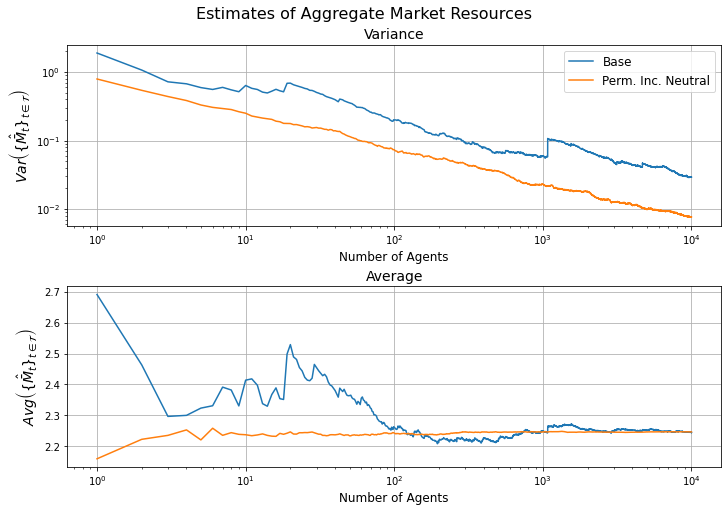

In [8]:
# Plots
nagents = np.arange(1,max_agents+1,1)

# Market resources
fig, axs = plt.subplots(2, figsize = (10,7), constrained_layout=True)

fig.suptitle('Estimates of Aggregate Market Resources', fontsize=16)
axs[0].plot(nagents, M_base['stds'], label = 'Base')
axs[0].plot(nagents, M_pin['stds'], label = 'Perm. Inc. Neutral')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title('Variance', fontsize=14)
axs[0].set_ylabel(r'$Var\left(\{\hat{\bar{M}}_t\}_{t\in\mathcal{T}}\right)$', fontsize = 14)
axs[0].set_xlabel('Number of Agents', fontsize=12)
axs[0].grid()
axs[0].legend(fontsize=12)

axs[1].plot(nagents, M_base['means'], label = 'Base')
axs[1].plot(nagents, M_pin['means'], label = 'Perm. Inc. Neutral')
axs[1].set_xscale('log')
axs[1].set_title('Average', fontsize=14)
axs[1].set_ylabel(r'$Avg\left(\{\hat{\bar{M}}_t\}_{t\in\mathcal{T}}\right)$', fontsize=14)
axs[1].set_xlabel('Number of Agents', fontsize=12)
axs[1].grid()
plt.show()

The previous plot highlights the gain in efficiency from Harmenberg's method: it attains any given level of precission ($\text{Var}\left(\{\hat{\bar{\textbf{M}}}_t\}_{t\in\mathcal{T}}\right)$) with roughly **one tenth** of the agents needed by the standard method to achieve that same level.

We now examine consumption.

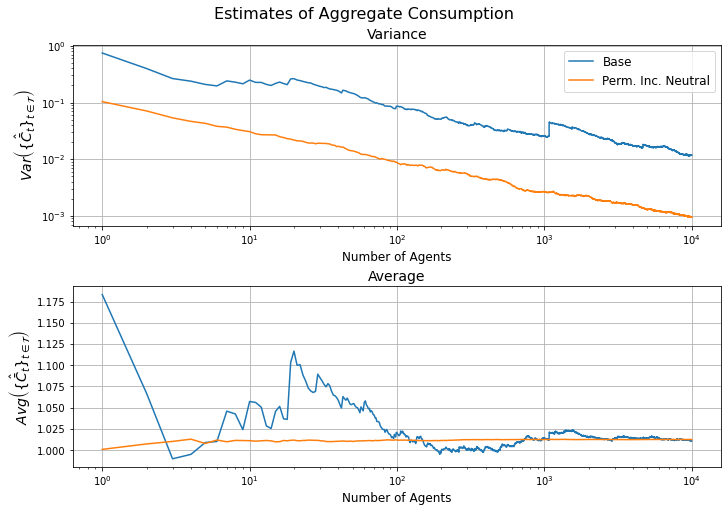

In [9]:
# Consumption
fig, axs = plt.subplots(2, figsize = (10,7), constrained_layout=True)

fig.suptitle('Estimates of Aggregate Consumption', fontsize=16)
axs[0].plot(nagents, C_base['stds'], label = 'Base')
axs[0].plot(nagents, C_pin['stds'], label = 'Perm. Inc. Neutral')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title('Variance', fontsize=14)
axs[0].set_ylabel(r'$Var\left(\{\hat{\bar{C}}_t\}_{t\in\mathcal{T}}\right)$', fontsize = 14)
axs[0].set_xlabel('Number of Agents', fontsize=12)
axs[0].grid()
axs[0].legend(fontsize=12)

axs[1].plot(nagents, C_base['means'], label = 'Base')
axs[1].plot(nagents, C_pin['means'], label = 'Perm. Inc. Neutral')
axs[1].set_xscale('log')
axs[1].set_title('Average', fontsize=14)
axs[1].set_ylabel(r'$Avg\left(\{\hat{\bar{C}}_t\}_{t\in\mathcal{T}}\right)$', fontsize=14)
axs[1].set_xlabel('Number of Agents', fontsize=12)
axs[1].grid()
plt.show()

The variance plot shows that the efficiency gains are even greater for consumption: Harmenberg's method requires rouglhy **one-hundredth** of the agents that the standard method would require for a given precision, and at a fixed number of agents it is **ten times more precise**!

# Comparison of the PIN-measure and the base measure

TODO

(0.0, 10.0)

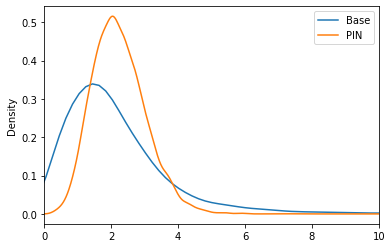

In [10]:
mdists = pd.DataFrame({'Base': M_base['dist_last'],
                       'PIN': M_pin['dist_last']})

mdists.plot.kde()
plt.xlim([0,10])